### Objective



Simulate federated learning across two “hospitals” using the Breast Cancer Wisconsin (Diagnostic) dataset without sharing raw data. Add a differential-privacy layer, compare against centralized training, and document privacy/utility trade-offs.


### Inputs

In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X,y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)

In [ ]:
#malignant = 0, begine = 1
y.value_counts()

,count
target,
1,357
0,212


In [ ]:
X.shape

(569, 30)

In [ ]:
top_10x_mean =X.mean().sort_values(ascending=False).head(10)

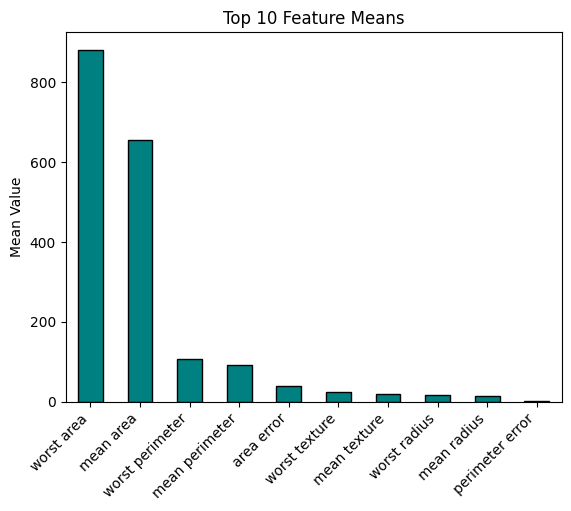

In [ ]:
top_10x_mean.plot(kind='bar', color='teal', edgecolor='black')

plt.ylabel("Mean Value")
plt.title("Top 10 Feature Means")
plt.xticks(rotation=45, ha='right')  # rotate labels for readability
plt.show()

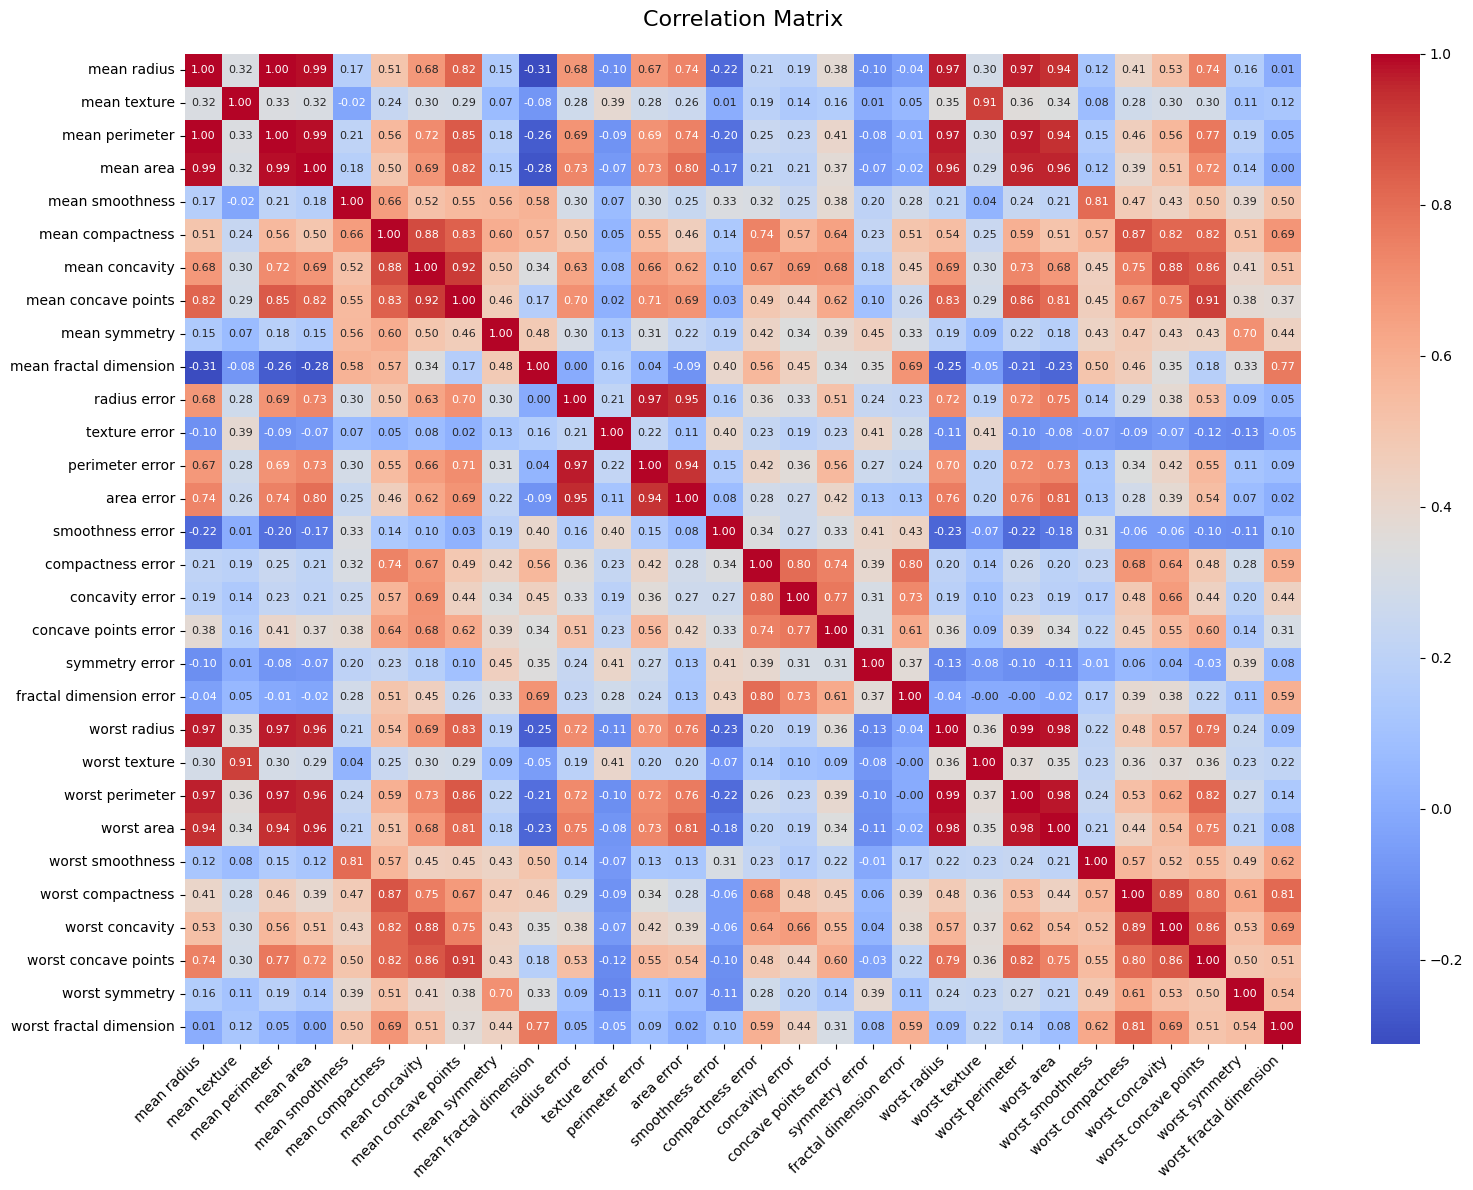

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = X.corr()

# Set larger figure size
plt.figure(figsize=(16, 12))  # adjust width x height

# Draw heatmap with clearer font sizes
sns.heatmap(
    corr_matrix,
    annot=True,           # show values
    fmt=".2f",            # 2 decimal places
    cmap="coolwarm",
    cbar=True,
    annot_kws={"size": 8} # smaller annotation text
)

plt.title("Correlation Matrix", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate correlation between y and each column in X
correlations = X.corrwith(y)
print(correlations.sort_values(ascending=False))

smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
concavity error           -0.253730
compactness error         -0.292999
worst fractal dimension   -0.323872
mean symmetry             -0.330499
mean smoothness           -0.358560
concave points error      -0.408042
mean texture              -0.415185
worst symmetry            -0.416294
worst smoothness          -0.421465
worst texture             -0.456903
area error                -0.548236
perimeter error           -0.556141
radius error              -0.567134
worst compactness         -0.590998
mean compactness          -0.596534
worst concavity           -0.659610
mean concavity            -0.696360
mean area                 -0.708984
mean radius               -0.730029
worst area                -0.733825
mean perimeter            -0.742636
worst radius              -0.776454
mean concave points       -0

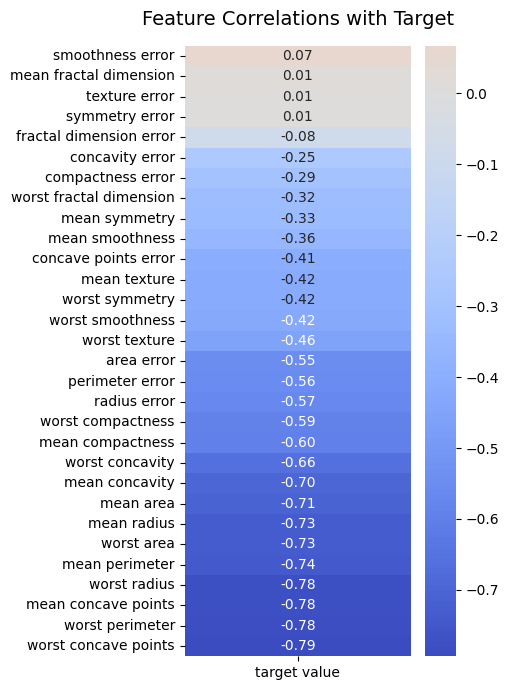

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Sort by strength
correlations = correlations.sort_values(ascending=False)

# Create a dataframe for heatmap
corr_df = correlations.to_frame(name="target value")

plt.figure(figsize=(5, 7))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    center=0,
    cbar=True,
    fmt=".2f",
    annot_kws={"size": 10}
)

plt.title("Feature Correlations with Target", fontsize=14, pad=15)
plt.yticks(rotation=0)  # keep feature names horizontal
plt.tight_layout()
plt.show()


## Create two non-IID(identical and independed distribution) hospital split

In [ ]:
#shuffle the datasets with fixed seed
X_shuffled = X.sample(frac=1, random_state=42)
y_shuffled = y.sample(frac=1, random_state=42)



In [ ]:
threthold = X['mean radius'].median()
#split 20% test data of the full data before splitting
X_test = X_shuffled[:int(0.2*len(X_shuffled))]
y_test = y_shuffled[:int(0.2*len(y_shuffled))]

# 80% percent reminder for training
X_train = X_shuffled[int(0.2*len(X_shuffled)):]
y_train = y_shuffled[int(0.2*len(y_shuffled)):]

#concate X_shuffled and y_shuffled to balance the data in train test split methods for the 80% traing and validation
data = pd.concat([X_train, y_train], axis=1)
hospital_A = data[data['mean radius'] > threthold]
hospital_B = data[data['mean radius'] <= threthold]

In [ ]:
print("the shape of X_train",X_train.shape)
print("the shape of hospital A ",hospital_A.shape)
print("the shape of hospital B",hospital_B.shape)


the shape of X_train (456, 30)
the shape of hospital A  (227, 31)
the shape of hospital B (229, 31)


In [ ]:
hospital_A.to_csv('hospital_A.csv', index=False)
hospital_B.to_csv('hospital_B.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Baseline certalized model(reference) use Hospital_A

In [ ]:
#load all required library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#read traing and test data on hospitalA
hospital_A = pd.read_csv('hospital_A.csv')
hospital_B  = pd.read_csv('hospital_B.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

In [ ]:
#isolate the target again for hospital a and b

X_train_hos_A = hospital_A.drop('target', axis=1)
y_train_hos_A = hospital_A['target']

X_train_hos_B = hospital_B.drop('target', axis=1)
y_train_hos_B = hospital_B['target']


In [ ]:
#train test split method for hospital_A
X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(X_train_hos_A,y_train_hos_A, test_size=0.2, random_state=42)

#define dictionary to use it showing the size for each split
data_dict = {
    "X_train_A": X_train_A,
    "y_train_A": y_train_A,
    "x_val_A": X_val_A,
    "y_val_A": y_val_A
}

# Accessing the variables using string keys
print("X_train_A",data_dict["X_train_A"].shape)
print("y_train_A",data_dict["y_train_A"].shape)
print('y_val_A',data_dict["y_val_A"].shape)
print("x_val_A", data_dict["x_val_A"].shape)


#


X_train_A (181, 30)
y_train_A (181,)
y_val_A (46,)
x_val_A (46, 30)


In [ ]:
#Apply standard scaller for features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_A = scaler.fit_transform(X_train_A)
X_val_A = scaler.transform(X_val_A)
X_test = scaler.transform(X_test)

In [ ]:
"""#show the distribution of the data after apply standardScaller


#convert numpy into dataframe
X_val_A = pd.DataFrame(X_val_A)
y_val_A = pd.DataFrame(y_val_A)
X_train_A = pd.DataFrame(X_train_A)
#convert columns into it's orginal names
X_val_A.columns = X_train.columns
X_train_A.columns = X_train.columns


#show the distribution for all features
for col in X_train_A.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(X_train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()"""


"#show the distribution of the data after apply standardScaller\n\n\n#convert numpy into dataframe\nX_val_A = pd.DataFrame(X_val_A)\ny_val_A = pd.DataFrame(y_val_A)\nX_train_A = pd.DataFrame(X_train_A)\n#convert columns into it's orginal names\nX_val_A.columns = X_train.columns\nX_train_A.columns = X_train.columns\n\n\n#show the distribution for all features\nfor col in X_train_A.columns:\n    plt.figure(figsize=(8, 6))\n    sns.histplot(X_train[col], kde=True)\n    plt.title(f'Distribution of {col}')\n    plt.xlabel(col)\n    plt.show()"

In [ ]:
#load models required
LR_model = LogisticRegression()
RF_model = RandomForestClassifier()

In [ ]:
#define a function that train and measure the accuracy
def train_and_evaluate(model, X_train, y_train, X_val, y_val):

    model.fit(X_train_A, y_train_A)
    #get prediction on x-val-a
    y_pred = model.predict(X_val_A)
    #appling accuracy, recall and f-score on y-predict and y_val_A
    accuracy = accuracy_score(y_val_A, y_pred)
    precision = precision_score(y_val_A, y_pred)
    recall = recall_score(y_val_A, y_pred)
    f1 = f1_score(y_val_A, y_pred)
    #show the result of metrix
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)



In [ ]:
#call the traing, accuracy function on Logistic regression
train_and_evaluate(LR_model, X_train_A, y_train_A, X_val_A, y_val_A)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [ ]:
#call the traing, accuracy function on Randomforest classifier
train_and_evaluate(RF_model, X_train_A, y_train_A, X_val_A, y_val_A)

Accuracy: 0.9782608695652174
Precision: 0.9230769230769231
Recall: 1.0
F1 Score: 0.96


# Baseline certalized model(reference) use Hospital_B

In [ ]:
#train test split method for hospital B
X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(X_train_hos_B,y_train_hos_B, test_size=0.2, random_state=42)
#find the shape for each dataset
print("X_train_B",X_train_B.shape)
print("y_train_B",y_train_B.shape)
print('y_val_B',y_val_B.shape)
print("x_val_B", X_val_B.shape)

X_train_B (183, 30)
y_train_B (183,)
y_val_B (46,)
x_val_B (46, 30)


In [ ]:
#Apply standard scaller for features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_B = scaler.fit_transform(X_train_B)
X_val_B = scaler.transform(X_val_B)


In [ ]:
#apply the train evaluate function for logistic regression
train_and_evaluate(LR_model, X_train_B, y_train_B, X_val_B, y_val_B)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [ ]:
#apply the train evaluate function for Random Forest
train_and_evaluate(RF_model, X_train_B, y_train_B, X_val_B, y_val_B)


Accuracy: 0.9782608695652174
Precision: 0.9230769230769231
Recall: 1.0
F1 Score: 0.96
